In [1]:
from __future__ import print_function, division
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from pyquil.quil import Program
from pyquil.api import QVMConnection, get_devices
from pyquil.gates import H, CNOT
import networkx as nx

DARK_TEAL = '#48737F'
FUSCHIA = '#D6619E'
BEIGE = '#FEFADA33'

In [2]:
devices = get_devices(as_dict=True)
devices

{u'19Q-Acorn': <Device 19Q-Acorn online>,
 u'8Q-Agave': <Device 8Q-Agave offline>}

In [3]:
try:
    acorn = devices['19Q-Acorn']
except KeyError:
    print("This notebook requires access to Rigetti's 19Q-Acorn device information.")

In [4]:
# def make_isa_graph(device):
device = acorn
nodes = [q.id for q in device.isa.qubits if not q.dead]
node_set = set(nodes)
edges = [e.targets for e in device.isa.edges if not e.dead and set(e.targets) <= node_set]

In [5]:
g = nx.graph.Graph(data=edges)

In [6]:
def node_to_pos(n, width=5, h=1, v=.3):
    """
    Convert a node index to a layout position for a degree-3 graph
    of a given width.
    """
    y0 = -(n // width)
    x = (n % width - (y0 % 2) * .5) * h
    return x, y0 * v    

In [7]:
node_positions = {n: node_to_pos(n) for n in nodes}

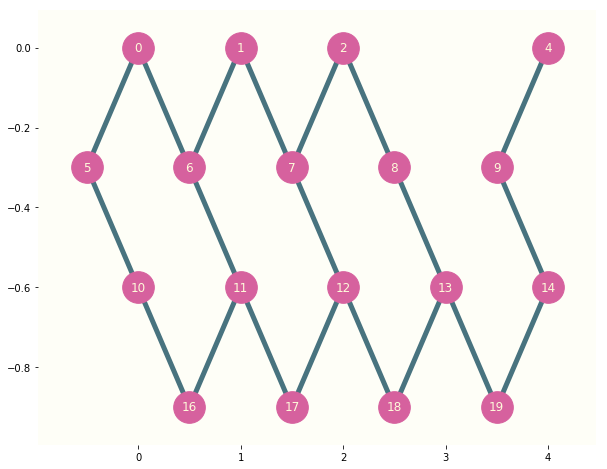

In [8]:
plt.figure(figsize=(10, 8))
nx.draw_networkx(g, 
                 with_labels=True, 
                 pos=node_positions, 
                 font_color=BEIGE,
                 node_color=FUSCHIA, 
                 node_size=1000, 
                 width=5,
                 edge_color=DARK_TEAL)
ax = plt.gca()
ax.set_facecolor(BEIGE)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

In [9]:
acorn_qvm = QVMConnection(
    device=acorn
)
qvm = QVMConnection()

In [10]:
q0, q1 = acorn.isa.edges[0].targets
p = Program(H(q0), CNOT(q0, q1)).measure(q0, 0).measure(q1, 1)

In [11]:
%%time 
job1 = acorn_qvm.wait_for_job(acorn_qvm.run_async(p, [0, 1], 1000))

job TKAsWPGetELOrXNY is currently queued at position 0. Estimated time until execution: 0.0 seconds.
job TKAsWPGetELOrXNY is currently running
job TKAsWPGetELOrXNY is currently running
CPU times: user 330 ms, sys: 25.4 ms, total: 356 ms
Wall time: 7.24 s


In [12]:
%%time
job2 = qvm.wait_for_job(qvm.run_async(p, [0, 1], 1000))

job iIrYdNPcAXgXlzDb is currently running
CPU times: user 24.2 ms, sys: 4.11 ms, total: 28.3 ms
Wall time: 1.26 s


In [13]:
# uncomment to see the full compiled quil file
# print(job1.compiled_quil())

# a QVMConnection without a device does not recompile the program
print(job2.compiled_quil())

H 0
CNOT 0 5
MEASURE 0 [0]
MEASURE 5 [1]



In [14]:
for case, job in zip(["acorn decoherence noise", "no noise"], [job1, job2]):
    r = np.asarray(job.result())
    zs = 1-2*r
    z1 = zs[:, 0]
    z2 = zs[:, 1]
    z1z2 = z1 * z2
    print("{}: <z1> = {}, <z2> = {}, <z1z2> = {}".format(case, z1.mean(), z2.mean(), z1z2.mean()))

acorn decoherence noise: <z1> = -0.042, <z2> = -0.022, <z1z2> = 0.796
no noise: <z1> = -0.022, <z2> = -0.022, <z1z2> = 1.0
